In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from kaggle_secrets import UserSecretsClient
from sklearn.model_selection import train_test_split

import wandb
import torch
import spacy
from spacy import displacy
nlp = spacy.blank('en')
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
df=pd.read_csv('/kaggle/input/26-label-dataset/merged_shuffled_dataset.csv')
df

,phrase,prompt
0,I have a ache in my lower makes it to,Back pain
1,regularly. I my My body feels weak although vi...,Body feels weak
2,Mr hair is just by combing,Hair falling out
3,I feel heart pain when I walk a lot,Heart hurts
4,I feel a bone-on-bone pain in my knees when I ...,Joint pain
...,...,...
41955,great I feel a great amount of pressure on the...,Shoulder pain
41956,When I stand up too quickly I start to feel di...,Feeling dizzy
41957,heavy breath with fatigue,Emotional pain
41958,iodine i can hardly breathe,Hard to breath


In [ ]:
df['prompt'].value_counts()

prompt
out of context        2000
Acne                  1968
Shoulder pain         1920
Knee pain             1884
Joint pain            1854
Infected wound        1830
Cough                 1758
Feeling dizzy         1698
Muscle pain           1692
Ear ache              1620
Heart hurts           1578
Head ache             1578
Skin issue            1578
Feeling cold          1578
Stomach ache          1566
Back pain             1566
Hair falling out      1524
Neck pain             1506
Body feels weak       1500
Internal pain         1488
Blurry vision         1476
Emotional pain        1446
Hard to breath        1392
Injury from sports    1380
Foot ache             1332
Open wound            1248
Name: count, dtype: int64

In [ ]:
evidence_labels = df.prompt.unique()

evidence_dict = {}
for index, evidence_labels in enumerate(evidence_labels):
    evidence_dict[evidence_labels] = index
evidence_dict

{'Back pain': 0,
 'Body feels weak': 1,
 'Hair falling out': 2,
 'Heart hurts': 3,
 'Joint pain': 4,
 'Knee pain': 5,
 'Head ache': 6,
 'Infected wound': 7,
 'Ear ache': 8,
 'Injury from sports': 9,
 'Feeling cold': 10,
 'Skin issue': 11,
 'Neck pain': 12,
 'Cough': 13,
 'Shoulder pain': 14,
 'Emotional pain': 15,
 'Feeling dizzy': 16,
 'Foot ache': 17,
 'Internal pain': 18,
 'out of context': 19,
 'Acne': 20,
 'Stomach ache': 21,
 'Blurry vision': 22,
 'Open wound': 23,
 'Hard to breath': 24,
 'Muscle pain': 25}

In [ ]:
df['Tags Mapped'] = df.prompt.map(evidence_dict)
df

,phrase,prompt,Tags Mapped
0,I have a ache in my lower makes it to,Back pain,0
1,regularly. I my My body feels weak although vi...,Body feels weak,1
2,Mr hair is just by combing,Hair falling out,2
3,I feel heart pain when I walk a lot,Heart hurts,3
4,I feel a bone-on-bone pain in my knees when I ...,Joint pain,4
...,...,...,...
41955,great I feel a great amount of pressure on the...,Shoulder pain,14
41956,When I stand up too quickly I start to feel di...,Feeling dizzy,16
41957,heavy breath with fatigue,Emotional pain,15
41958,iodine i can hardly breathe,Hard to breath,24


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,\
                                                  df['Tags Mapped'].values,\
                                                  test_size=0.15,\
                                                  random_state=42,\
                                                  stratify=df['Tags Mapped'].values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['prompt', 'Tags Mapped', 'data_type']).count()

phrase
prompt             Tags Mapped data_type        
Acne               20          train        1673
                               val           295
Back pain          0           train        1331
                               val           235
Blurry vision      22          train        1255
                               val           221
Body feels weak    1           train        1275
                               val           225
Cough              13          train        1494
                               val           264
Ear ache           8           train        1377
                               val           243
Emotional pain     15          train        1229
                               val           217
Feeling cold       10          train        1341
                               val           237
Feeling dizzy      16          train        1443
                               val           255
Foot ache          17          train        1132
                               val           200
Hair falling out   2           train        1296
                               val           228
Hard to breath     24          train        1183
                               val           209
Head ache          6           train        1341
                               val           237
Heart hurts        3           train        1341
                               val           237
Infected wound     7           train        1556
                               val           274
Injury from sports 9           train        1173
                               val           207
Internal pain      18          train        1265
                               val           223
Joint pain         4           train        1576
                               val           278
Knee pain          5           train        1602
                               val           282
Muscle pain        25          train        1438
                               val           254
Neck pain          12          train        1280
                               val           226
Open wound         23          train        1061
                               val           187
Shoulder pain      14          train        1632
                               val           288
Skin issue         11          train        1341
                               val           237
Stomach ache       21          train        1331
                               val           235
out of context     19          train        1700
                               val           300

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True,truncation=True)

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].phrase.values,
    add_special_tokens=True,
    return_attention_mask=True,
    truncation=True,
    padding='longest',
    max_length=512,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].phrase.values,
    add_special_tokens=True,
    truncation=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
tags_train = torch.tensor(df[df.data_type=='train']['Tags Mapped'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
tags_val = torch.tensor(df[df.data_type=='val']['Tags Mapped'].values)

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, tags_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, tags_val)

In [ ]:
print(len(dataset_train), len(dataset_val))

35666 6294


## Model Training

In [ ]:
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2",
                                                      num_labels=len(evidence_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      hidden_dropout_prob=0.3 )

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 32 #Defining Batch Size on which model has to be trained

# Converting tensors Dataset to dataloaders so that model can be trained
dataloader_train = DataLoader(dataset_train,sampler=RandomSampler(dataset_train), batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,  # Learning rate
    eps=1e-8,  # Epsilon for numerical stability
    weight_decay=0.01  # L2 regularization

)

In [ ]:
epochs = 10
total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # Can adjust this
    num_training_steps=total_steps
)

In [ ]:
def apply_temperature_scaling(logits, temperature=2.0):
    # Scale the logits to reduce confidence
    return logits / temperature

In [ ]:
# Function to calculate F1 score
def f1_score_func(preds, tags):
    preds_flat = np.argmax(preds, axis=1).flatten()
    tags_flat = tags.flatten()
    return f1_score(tags_flat, preds_flat, average='weighted')

# Function to calculate accuracy per class
def accuracy_per_class(preds, tags):
    evidence_dict_inverse = {v: k for k, v in evidence_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    tags_flat = tags.flatten()

    for tag in np.unique(tags_flat):
        y_preds = preds_flat[tags_flat == tag]
        y_true = tags_flat[tags_flat == tag]
        print(f'PICO Evidence Class: {evidence_dict_inverse[tag]}')
        print(f'Accuracy: {len(y_preds[y_preds==tag])}/{len(y_true)}\n')

In [ ]:
# Setting seeds for reproducibility
seed_val = 199
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val, temperature=2.0):  # Add temperature as a parameter
    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        # Apply temperature scaling before softmax
        scaled_logits = apply_temperature_scaling(logits, temperature)
        probs = torch.softmax(scaled_logits, dim=-1)  # Now softmax with scaled logits

        logits = probs.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals


In [ ]:
!mkdir models #creating Directory for model storing

In [ ]:
# Lists to track training and validation loss, and F1 scores
loss_train_avg_list = []
val_loss_list = []
val_f1_list = []

# Training loop
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc=f'Epoch {epoch}', leave=False, disable=False)

    for batch in progress_bar:
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    # Save model after each epoch
    torch.save(model.state_dict(), f'models/finetuned_BioBERT_epoch_{epoch}.model')

    # Print training loss
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    loss_train_avg_list.append(loss_train_avg)

    # Validation evaluation with temperature scaling
    val_loss, predictions, true_vals = evaluate(dataloader_validation, temperature=2.0)  # Applying temperature scaling during validation
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    val_loss_list.append(val_loss)
    tqdm.write(f'F1 validation Score (Weighted): {val_f1}')
    val_f1_list.append(val_f1)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.791374854362599
Validation loss: 0.5771946509931293
F1 validation Score (Weighted): 0.8624411655743734


Epoch 2:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5321326031078137
Validation loss: 0.28500222592486946
F1 validation Score (Weighted): 0.9279271126164597


Epoch 3:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3042829248770203
Validation loss: 0.1988921948250024
F1 validation Score (Weighted): 0.9459663120028943


Epoch 4:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.20952206613003138
Validation loss: 0.16278383944202499
F1 validation Score (Weighted): 0.9566952641342418


Epoch 5:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.15597896149189883
Validation loss: 0.13385468589491803
F1 validation Score (Weighted): 0.9640349039244887


Epoch 6:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.11700074292944886
Validation loss: 0.11035559281380611
F1 validation Score (Weighted): 0.9724967812639654


Epoch 7:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.09290902735999547
Validation loss: 0.09689103589844678
F1 validation Score (Weighted): 0.976202576223967


Epoch 8:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0777760621924538
Validation loss: 0.093088543676029
F1 validation Score (Weighted): 0.9771340999441734


Epoch 9:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.06692132476358069
Validation loss: 0.08542736912344767
F1 validation Score (Weighted): 0.978713663730196


Epoch 10:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.06172201770249203
Validation loss: 0.08378982000398039
F1 validation Score (Weighted): 0.979499603769029


In [ ]:
model.load_state_dict(torch.load('models/finetuned_BioBERT_epoch_10.model', map_location=torch.device('cuda')))

<All keys matched successfully>

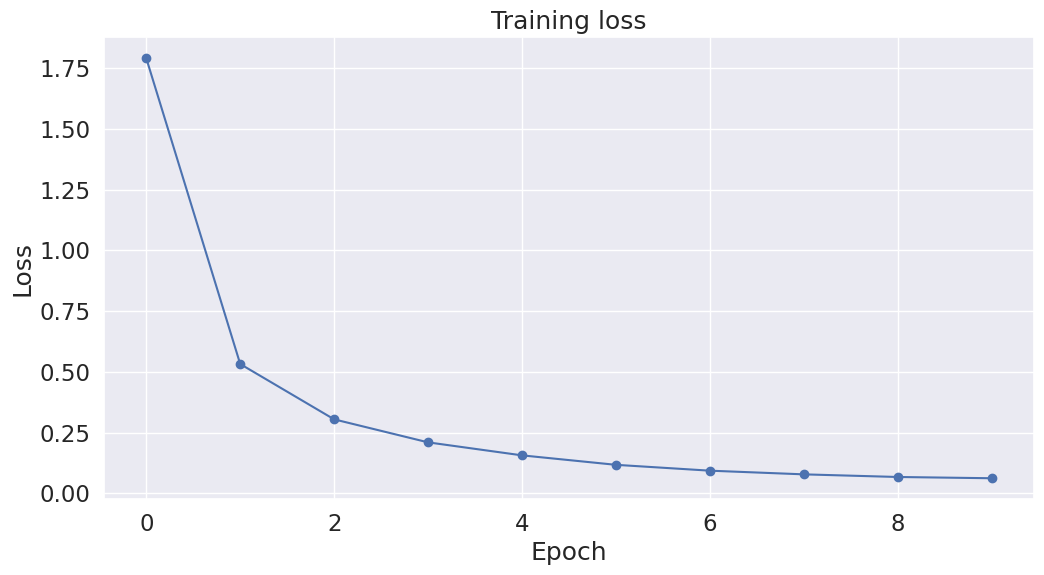

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(loss_train_avg_list, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

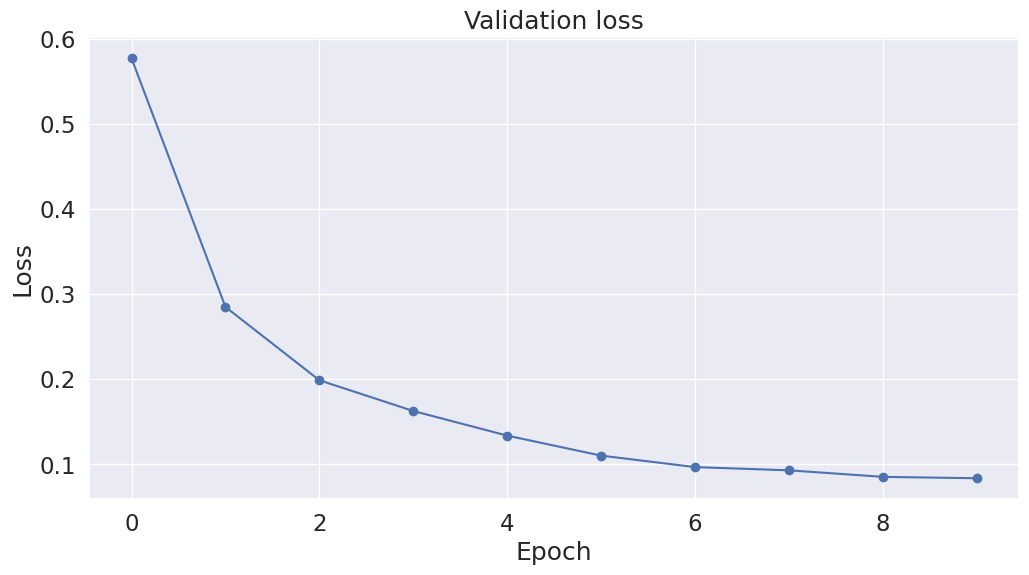

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(val_loss_list, 'b-o')

plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

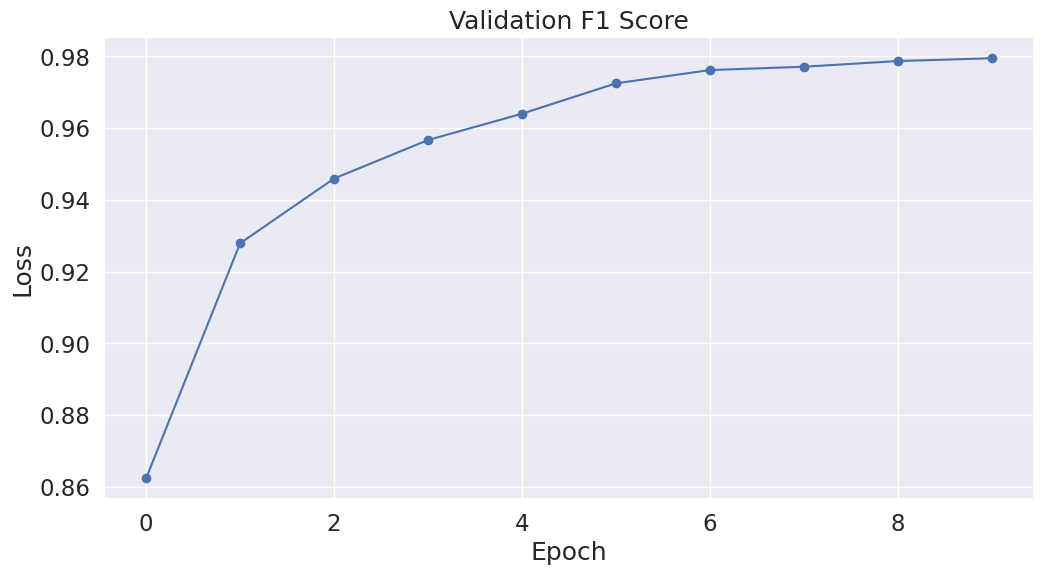

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(val_f1_list, 'b-o')

plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

PICO Evidence Class: Back pain
Accuracy: 231/235

PICO Evidence Class: Body feels weak
Accuracy: 215/225

PICO Evidence Class: Hair falling out
Accuracy: 227/228

PICO Evidence Class: Heart hurts
Accuracy: 231/237

PICO Evidence Class: Joint pain
Accuracy: 265/278

PICO Evidence Class: Knee pain
Accuracy: 276/282

PICO Evidence Class: Head ache
Accuracy: 226/237

PICO Evidence Class: Infected wound
Accuracy: 271/274

PICO Evidence Class: Ear ache
Accuracy: 235/243

PICO Evidence Class: Injury from sports
Accuracy: 205/207

PICO Evidence Class: Feeling cold
Accuracy: 235/237

PICO Evidence Class: Skin issue
Accuracy: 236/237

PICO Evidence Class: Neck pain
Accuracy: 222/226

PICO Evidence Class: Cough
Accuracy: 262/264

PICO Evidence Class: Shoulder pain
Accuracy: 286/288

PICO Evidence Class: Emotional pain
Accuracy: 210/217

PICO Evidence Class: Feeling dizzy
Accuracy: 253/255

PICO Evidence Class: Foot ache
Accuracy: 195/200

PICO Evidence Class: Internal pain
Accuracy: 215/223

PICO

In [ ]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("transcript")

In [ ]:
!sudo apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [ ]:
model.push_to_hub(repo_id='***', use_auth_token='')

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/samirangupta31/Chatbot_Classifier/commit/301a9fdb63f778013e3b769302be1b8ad18121f8', commit_message='Upload BertForSequenceClassification', commit_description='', oid='301a9fdb63f778013e3b769302be1b8ad18121f8', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub(repo_id='***', use_auth_token='')

CommitInfo(commit_url='https://huggingface.co/samirangupta31/Chatbot_Classifier/commit/a6747428c1b0cbd9f808cc9bab2c0a1798f621cb', commit_message='Upload tokenizer', commit_description='', oid='a6747428c1b0cbd9f808cc9bab2c0a1798f621cb', pr_url=None, pr_revision=None, pr_num=None)

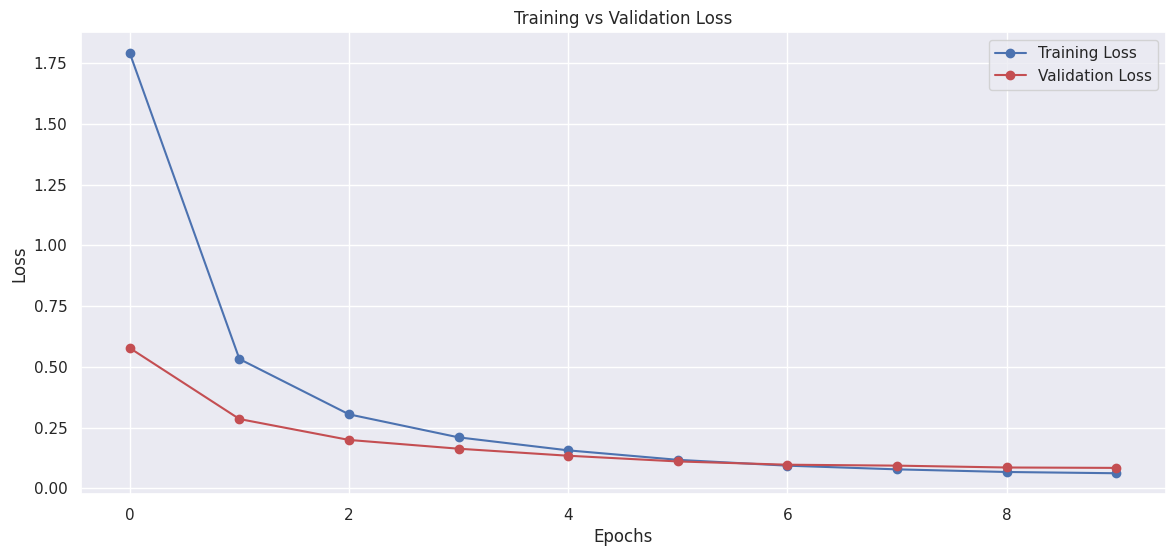

In [ ]:
sns.set(style='darkgrid')
plt.figure(figsize=(14,6))

# Training Loss
plt.plot(loss_train_avg_list, 'b-o', label="Training Loss")

# Validation Loss
plt.plot(val_loss_list, 'r-o', label="Validation Loss")

plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


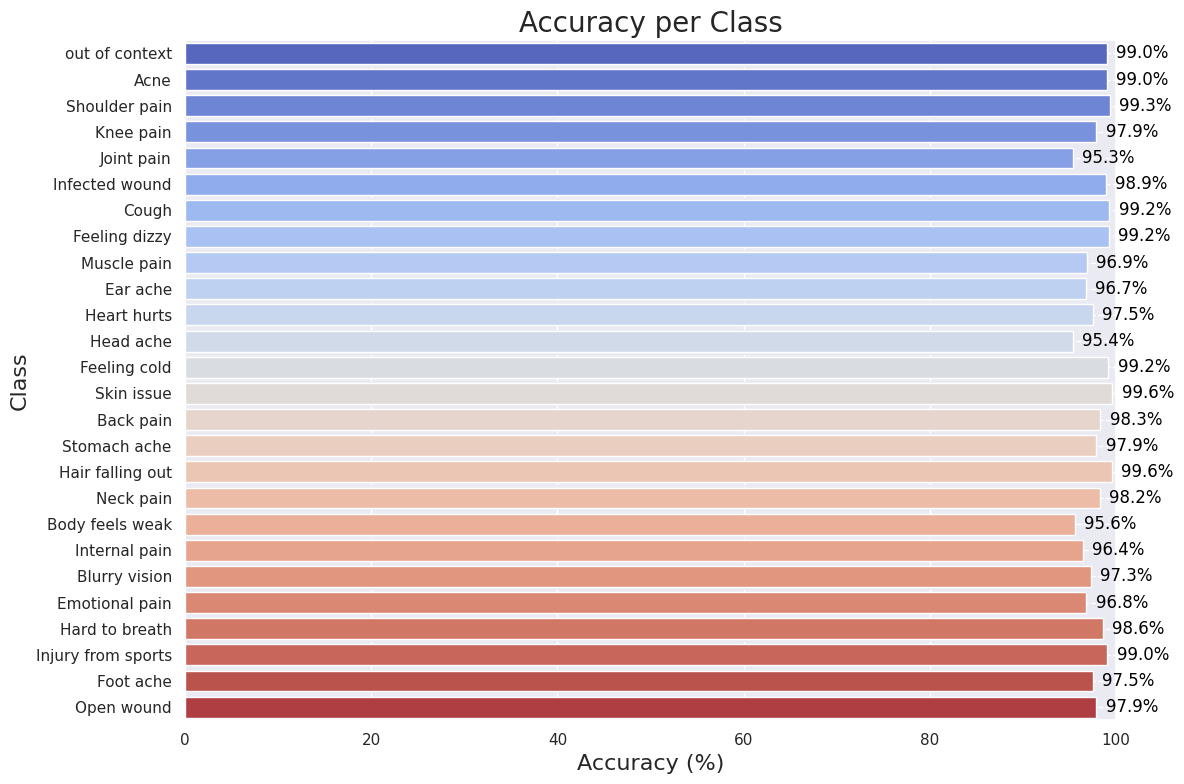

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def accuracy_per_class(preds, tags, evidence_dict):
    evidence_dict_inverse = {v: k for k, v in evidence_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    tags_flat = tags.flatten()

    # Dictionary to store accuracy per class
    accuracy_dict = {}
    tag_counts = Counter(tags_flat)  # Count occurrences of each class

    for tag in np.unique(tags_flat):
        y_preds = preds_flat[tags_flat == tag]
        y_true = tags_flat[tags_flat == tag]

        accuracy = len(y_preds[y_preds == tag]) / len(y_true) if len(y_true) > 0 else 0
        accuracy_dict[evidence_dict_inverse[tag]] = accuracy * 100  # Convert to percentage

    return accuracy_dict, tag_counts

# Call the accuracy function
accuracy_dict, tag_counts = accuracy_per_class(predictions, true_vals, evidence_dict)

# Sort accuracy dictionary by the total number of tags for each class
sorted_accuracy = sorted(accuracy_dict.items(), key=lambda item: tag_counts[evidence_dict[item[0]]], reverse=True)

# Unzip the sorted results
classes, accuracies = zip(*sorted_accuracy)

# Check data types and ensure they are lists
classes = list(classes)
accuracies = list(accuracies)

# Ensure accuracies are numeric
accuracies = [float(a) for a in accuracies]

# Plotting the accuracies per class
plt.figure(figsize=(12, 8))
sns.barplot(x=accuracies, y=classes, palette='coolwarm')
plt.title('Accuracy per Class', fontsize=20)
plt.xlabel('Accuracy (%)', fontsize=16)
plt.ylabel('Class', fontsize=16)
plt.xlim(0, 100)  # Assuming accuracy is in percentage

for index, value in enumerate(accuracies):
    plt.text(value + 1, index, f'{value:.1f}%', color='black', va='center', fontsize=12)

plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()


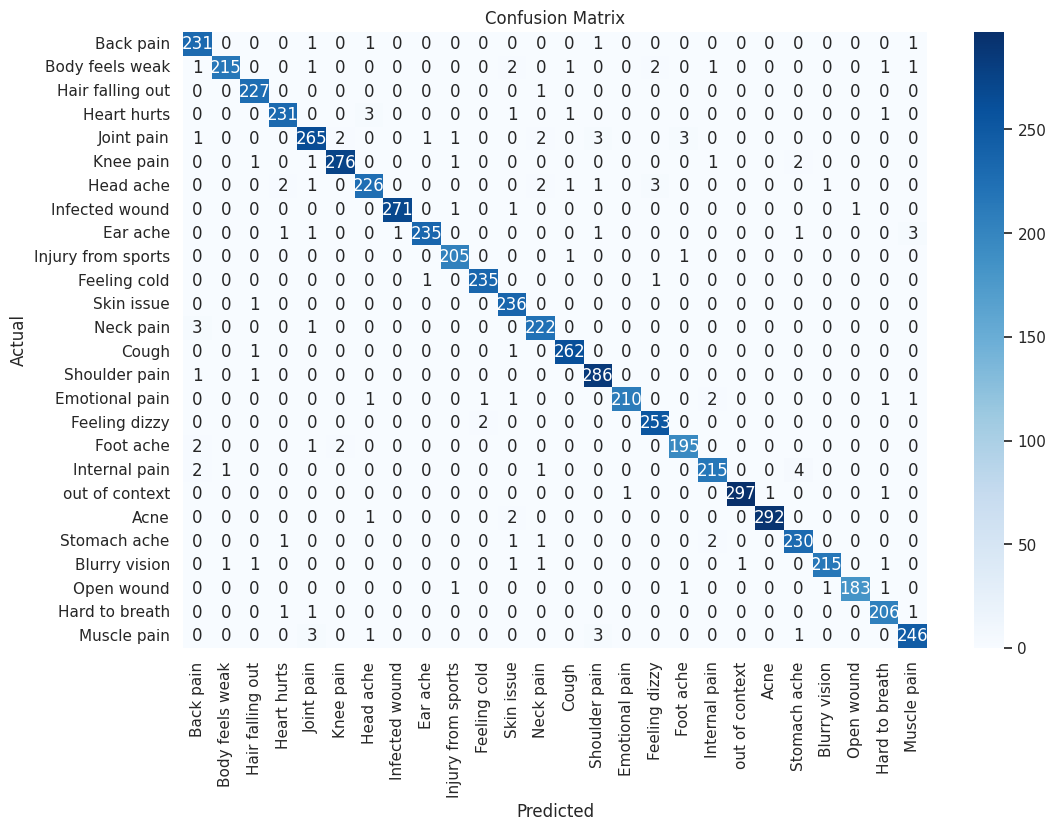

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming `true_labels` and `predictions` contain true and predicted labels respectively
cm = confusion_matrix(true_vals, np.argmax(predictions, axis=1))

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=evidence_dict.keys(), yticklabels=evidence_dict.keys())
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
